In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_cv

2024-06-14 17:37:27.041845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# CONSTANTES
BATCH_SIZE = 48
IMG_SIZE = 32
NUM_CLASSES = 10  # nº classes para identificar
NUM_EPOCHS = 60
LEARNING_RATE = 0.001
DROPOUT_RATES = [0.3, 0.4, 0.4, 0.5, 0.5]

In [3]:
# Folders do dataset
train_dirs = ['./dataset/train/train1', './dataset/train/train2', './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

2024-06-14 17:37:29.039181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 17:37:29.045228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 17:37:29.045472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

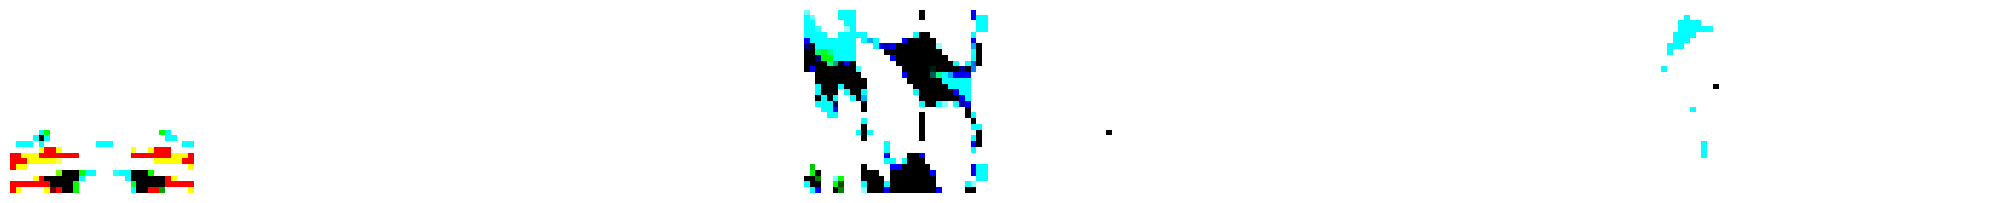

2024-06-14 17:37:37.166797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


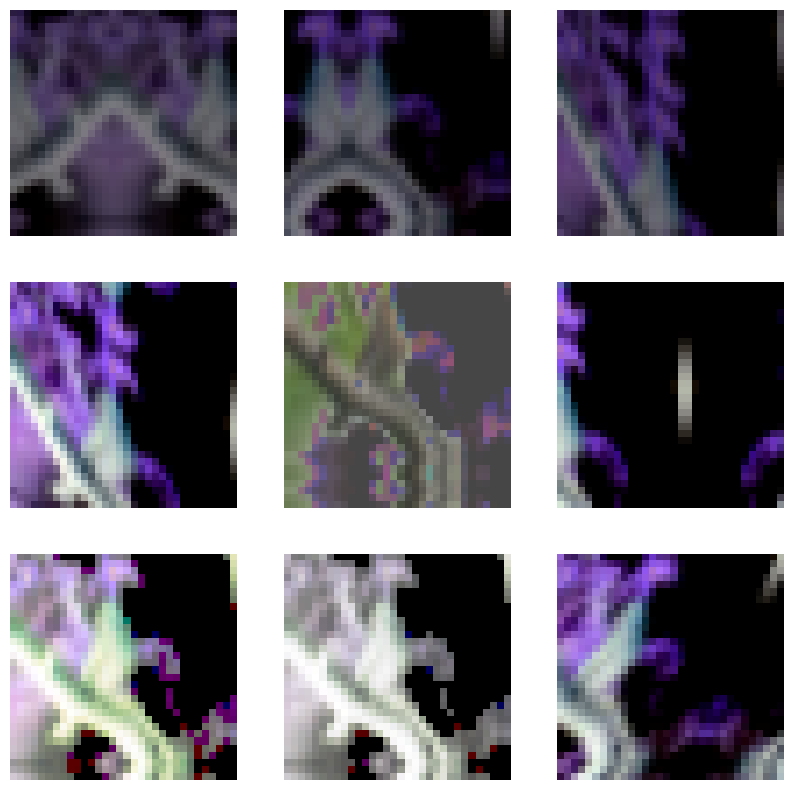

2024-06-14 17:37:41.162991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Define the data augmentation using KerasCV
augmenter = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.5
)

# Function to load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Function to load dataset from directory
def create_dataset(directory, batch_size, augment=False):
    dataset = tf.data.Dataset.list_files(os.path.join(directory, '*/*'))
    dataset = dataset.map(lambda x: (x, tf.strings.split(x, os.path.sep)[-2] == tf.constant([
        'class1', 'class2', 'class3', 'class4', 'class5',
        'class6', 'class7', 'class8', 'class9', 'class10'])))
    dataset = dataset.map(load_and_preprocess_image)
    if augment:
        dataset = dataset.map(lambda x, y: (augmenter(x), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create multiple train datasets
train_datasets = [create_dataset(train_dir, BATCH_SIZE, augment=True) for train_dir in train_dirs]

# Combine train datasets
train_dataset = train_datasets[0]
for ds in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(ds)

# Create validation and test datasets
validation_dataset = create_dataset(validation_dir, BATCH_SIZE)
test_dataset = create_dataset(test_dir, BATCH_SIZE)

# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('./plot.png')
    plt.show()

# Generate a batch of images and display them
for images, _ in train_dataset.take(1):
    plot_images(images[:10].numpy())

# Visualize augmented images
def visualize_augmentation(image, augmenter):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = augmenter(tf.expand_dims(image, 0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

# Take a single image from the dataset for visualization
for images, _ in train_dataset.take(1):
    image = images[0]
    visualize_augmentation(image, augmenter)

In [5]:

# Definir as layers do modelo
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(DROPOUT_RATES[0]),
    
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(DROPOUT_RATES[1]),
    
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(DROPOUT_RATES[2]),
    
    Conv2D(512, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(DROPOUT_RATES[3]),
    
    Flatten(),
    Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(DROPOUT_RATES[4]),
    
    Dense(NUM_CLASSES, activation='softmax')
])
# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 2,611,082 (9.96 MB)

 Trainable params: 2,608,138 (9.95 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [6]:
# CALLBACKS
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
csv_logger = CSVLogger(f'training_log_batch_size_{BATCH_SIZE}.csv', append=True)

In [7]:
# calcular passos por epoch
#steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])

# Treinar o modelo - Nao tirar os callbacks
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=validation_dataset,
    callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger]
)

# Avaliar o modelo no test generator
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

Epoch 1/30


I0000 00:00:1718386665.731806    3135 service.cc:145] XLA service 0x1663a6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718386665.731840    3135 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-14 17:37:45.854104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 17:37:46.188714: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  6/836 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.0368 - loss: 1.4248   

I0000 00:00:1718386674.294672    3135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


417/836 ━━━━━━━━━━━━━━━━━━━━ 58s 140ms/step - accuracy: 0.0271 - loss: 1.4589

KeyboardInterrupt: 

In [ ]:
# Function to save the plot of training history
def plot_training_history(history, batch_size, output_base_dir='./plots'):
    output_dir = f"{output_base_dir}/batch_size_{batch_size}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.figure(figsize=(12, 8))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    
    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, max(history.history['loss'])])
    plt.legend(loc='upper right')

    # Add titles and text box with parameters
    plt.suptitle('Training History', fontsize=16)
    textstr = '\n'.join((
        f'Batch Size: {batch_size}',
        f'Learning Rate: {LEARNING_RATE}',
        f'Dropout Rates: {DROPOUT_RATES}',
        f'Number of Layers: {len(model.layers)}',
        f'Dense Layer: 512 units'))
    
    plt.gcf().text(0.15, 0.6, textstr, fontsize=12)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

# Plot and save the training history
plot_training_history(history, BATCH_SIZE)